# Generating Images of Cats and Dogs -- Group 35
## Evaluation
Gustav Lahti (lahtig@student.chalmers.se) and Agnes Mårdh (agnesma@student.chalmers.se)

## Imports

In [1]:
import os

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils

import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import clear_output

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining various global parameters

In [3]:
# Root for images
dataroot = "train"

# Number of workers for dataloader
workers = 2

# Batch size
batch_size = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

## Initializing DataSet and DataLoader
`dataset` and `dataloader` are only used for manual evaluation.

In [4]:
dataset = ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

## Various functions to help with evaluation

### Compare real pictures to generated images

In [5]:
def compare_real_gen(dataloader, model):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the generated fake images
    noise = torch.randn(real_batch.shape[0], 100, 1, 1, device=device)
    fake_images = model.forward(noise)
    
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(fake_images, (1,2,0)))
    plt.show()

### Get images from the real dataset, generated images, or one of each

In [6]:
def create_real_image(dataloader):
    real = next(iter(dataloader))
    return real[0][0] 
    
def create_fake_images(model, is_cond=False, batch_size=1):
    noise = torch.randn(batch_size, 100, 1, 1, device=device)
    
    if is_cond:
        fake_labels = torch.randint(0,2,(batch_size,)).to(device)
        fake = model.forward(noise, fake_labels)
        
        return fake, fake_labels
    else:
        fake = model.forward(noise)
        
        return fake, None
    

def create_images_mixed(dataloader, model, is_cond=False):
    real = create_real_image(dataloader)
    
    fake, fake_labels = create_fake_images(model, is_cond)
    
    return real, fake, fake_labels

### Display an image on the provided axes

In [20]:
def plot_image(img, axes):
    img = vutils.make_grid(img, normalize=True)
    img = np.transpose(img, (1,2,0)) #img.permute(1, 2, 0).numpy()
    
    height, width, _ = img.shape
    
    axes.axis("off")
    axes.imshow(img)
    axes.set_xlim(0, width)
    axes.set_ylim(height, 0)

### Display one generated and one real image next to each other in a randomized order

In [19]:
def show_images_mixed(real, fake):
    fig, axes = plt.subplots(1,2)
    
    real_index = random.randint(0, 1)
    fake_index = 1 - real_index 
    
    plot_image(real, axes[real_index])
    
    fake = fake[0].to("cpu").detach()
    plot_image(fake, axes[fake_index])
    
    axes[0].set_title("0")
    axes[1].set_title("1")
    
    plt.show()
    x = input("Guess which image is generated: ")
    # Clear output
    return fake_index, x;

## Generator from the regular GAN

In [9]:
class UnconditionalGenerator(nn.Module):
    def __init__(self, ngpu):
        super(UnconditionalGenerator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## Generator from the conditional GAN

In [10]:
class ConditionalGenerator(nn.Module):
    def __init__(self, ngpu):
        super(ConditionalGenerator, self).__init__()
        self.ngpu = ngpu
        
        self.label_emb = nn.Embedding(2, 2)
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz + 2, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input, labels):
        c = self.label_emb(labels).view(input.shape[0], 2, 1, 1)
        input = torch.cat([input, c], 1)
        return self.main(input)

## Create instances of the generators and load the weights from previously trained generators

In [11]:
unc_model = UnconditionalGenerator(ngpu).to(device)
unc_model.load_state_dict(torch.load("unc_netG", map_location=device))

cond_model = ConditionalGenerator(ngpu).to(device)
cond_model.load_state_dict(torch.load("cond_netG", map_location=device))

<All keys matched successfully>

## Define a function that allows a human to guess which of two pictures is fake

In [12]:
def binary_classification(dataloader, model, n_tests, is_cond):
    results = []
    
    for _ in range(n_tests): 
        real, fake, _ = create_images_mixed(dataloader, model, is_cond)
        results.append(show_images_mixed(real, fake))
        clear_output(wait=True)

    correct_guesses = [x == int(y) for x, y in results]
    
    return correct_guesses

## Evaluation: Can a human differentiate between generated and real images?

In [21]:
n_tests = 1

results = []

results.append(binary_classification(dataloader, unc_model, n_tests, False))
results.append(binary_classification(dataloader, cond_model, n_tests, True))

print("Unconditional:\t{0}/{2} correct\nConditional:\t{1}/{2} correct".format(sum(results[0]), sum(results[1]), n_tests))

Unconditional:	1/1 correct
Conditional:	1/1 correct


## Helper-function to make layer-size calculations less tedious

In [15]:
def LayerSize(input_size, kernel_size, stride, padding):
    return (input_size + 2 * padding - kernel_size) // stride + 1

## CNN used in Adversarial Accuracy and Adversarial Divergence

In [23]:
class EvalNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.last_filter_dim = 32
        
        self.conv0 = nn.Conv2d(in_channels=3,  out_channels=8,                    kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels=8,  out_channels=16,                   kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=self.last_filter_dim, kernel_size=3)
        
        self.batch0  = nn.BatchNorm2d(8)
        self.batch1  = nn.BatchNorm2d(16)
        self.batch2  = nn.BatchNorm2d(32)
        
        self.fc_size = LayerSize(input_size,   3, 1, 0) # Size after conv0
        self.fc_size = LayerSize(self.fc_size, 3, 1, 0) # Size after conv1
        self.fc_size = LayerSize(self.fc_size, 3, 1, 0) # Size after conv2
        self.fc_size = LayerSize(self.fc_size, 2, 2, 0) # Size after max pooling 0
        
        self.fc0 = nn.Linear(self.fc_size**2 * self.last_filter_dim, 500)
        self.fc1 = nn.Linear(500, 2)
        
        
    def forward(self, x):
        x = self.batch0(F.relu(self.conv0(x)))
        x = self.batch1(F.relu(self.conv1(x)))
        x = self.batch2(F.relu(self.conv2(x)))
        
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.reshape(x, (-1, self.fc_size**2 * self.last_filter_dim))
        x = F.relu(self.fc0(x))
        
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

### Instanciates one CNN that will train on real data and one that will train on generated data

In [24]:
eval_real = EvalNet(64)
eval_fake = EvalNet(64)

## Function for defining DataSets and DataLoaders for real and generated images. Will generate the images if needed, will otherwise load the previously generated images.

In [18]:
def create_datasets(dataroot, model, batch_size=128):
    real_dataset = ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    # Create the dataloader
    real_dataloader = DataLoader(real_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

    dataset_size = len(real_dataset)
    
    # Generate dataset if it has not been generated in a previous run
    fake_root = "generated_" + dataroot
    if not os.path.isdir(fake_root):
        cat_path = fake_root + os.path.sep + "cats"
        dog_path = fake_root + os.path.sep + "dogs"
        
        os.mkdir(fake_root)
        os.mkdir(cat_path)
        os.mkdir(dog_path)
        
        instance_amnt = dataset_size // 2
        
        # Get lists of labels
        cat_labels = torch.zeros((instance_amnt,), dtype=torch.long)
        dog_labels = torch.ones((instance_amnt,),  dtype=torch.long)
        
        # Get random noise for the generator
        cat_noise = torch.randn(instance_amnt, nz, 1, 1)
        dog_noise = torch.randn(instance_amnt, nz, 1, 1)
        
        # Need to generate the images on the CPU because I get timeouts on the GPU, a problem with Windows
        model.to("cpu")
        
        # Generate pictures as tensors
        cat_tensor = model(cat_noise, cat_labels)
        dog_tensor = model(dog_noise, dog_labels)
        
        # Save images to directories
        for i in range(instance_amnt):
            vutils.save_image(cat_tensor[i], "{}{}{}.png".format(cat_path, os.path.sep, i))
            
        for i in range(instance_amnt):
            vutils.save_image(dog_tensor[i], "{}{}{}.png".format(dog_path, os.path.sep, i + instance_amnt))
        cat_tensor = None
        dog_tensor = None
    
    # Create fake dataset and loader from directories
    fake_dataset    = ImageFolder(root=fake_root, transform=transforms.Compose([transforms.ToTensor()]))
    fake_dataloader = DataLoader(fake_dataset, batch_size=batch_size,shuffle=True, num_workers=2)
    
    return real_dataset, real_dataloader, fake_dataset, fake_dataloader

### Instanciate the DataSets and DataLoaders for real and fake training and validation

In [19]:
# This will probably kill your kernel on the first run. This is not a feature, but a seemingly necessary bug
r_ds_train, r_dl_train, f_ds_train, f_dl_train = create_datasets("train", cond_model)
r_ds_val,   r_dl_val,   f_ds_val,   f_dl_val   = create_datasets("val",   cond_model)

## Functions used for training the CNNs

In [21]:
def evaluate_model(val_data_loader, val_dataset, model, loss_fn):
    losses = []
    n_correct = 0
    with torch.no_grad():
        for b_x, b_y in val_data_loader:
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            
            hard_preds = pred.argmax(dim=1)
            n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()
        val_accuracy = n_correct/len(val_dataset)
        val_avg_loss = sum(losses)/len(losses)    
    
    return val_accuracy, val_avg_loss

def train_model(model, 
                loss_fn, 
                optimizer, 
                epoch_num, 
                train_dataset, 
                train_data_loader, 
                val_dataset, 
                val_data_loader, 
                verboser=False,
                batch_print_num=10):
    train_losses = []
    train_accs   = []
    val_losses   = []
    val_accs     = []
    
    model.to(device)

    for epoch in range(epoch_num):
        losses = []
        n_correct = 0
        
        batch_counter = 0
        batch_n       = 0
        batch_correct = 0
        batch_loss    = []
        
        for b_x, b_y in train_data_loader:
            batch_counter += 1
            
            b_x = b_x.to(device)
            b_y = b_y.to(device)

            # Compute predictions and losses
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            batch_loss.append(loss.item())

            # Count number of correct predictions
            hard_preds = pred.argmax(dim=1)
            correct    = torch.sum(pred.argmax(dim=1) == b_y).item()
            n_correct += correct
            
            batch_n       += len(b_y)
            batch_correct += correct
            
            if verboser and batch_counter >= batch_print_num:
                print("Batch loss: {:.3f}\tBatch acc: {:.2f}".format(sum(batch_loss)/len(batch_loss), 
                                                                     batch_correct/batch_n))
                batch_counter = 0
                batch_n       = 0
                batch_correct = 0
                batch_loss    = []

            # Backpropagate
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_accuracy = n_correct/len(train_dataset)
        train_avg_loss = sum(losses)/len(losses)

        train_accs.append(train_accuracy)
        train_losses.append(train_avg_loss)

        # Compute accuracy and loss in the entire validation set
        val_accuracy, val_avg_loss = evaluate_model(val_data_loader, val_dataset, model, loss_fn)
        val_accs.append(val_accuracy)
        val_losses.append(val_avg_loss)

        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        display_str += '\tAccuracy: {:.2f} '
        display_str += '\tAccuracy (val): {:.2f}'
        print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))
        
    return model, train_accs, train_losses, val_accs, val_losses

## Train the CNNs

In [25]:
epoch_num = 15
lr        = 0.01

loss_fn     = nn.NLLLoss()
optimizer_r = optim.Adam(eval_real.parameters(), lr=lr)
optimizer_f = optim.Adam(eval_fake.parameters(), lr=lr)
    
_, r_ta, r_tl, r_va, r_vl = train_model(eval_real, 
                                        loss_fn, 
                                        optimizer_r, 
                                        epoch_num, 
                                        r_ds_train, 
                                        r_dl_train, 
                                        r_ds_val, 
                                        r_dl_val)
_, f_ta, f_tl, f_va, f_vl = train_model(eval_fake, 
                                        loss_fn, 
                                        optimizer_f, 
                                        epoch_num, 
                                        f_ds_train, 
                                        f_dl_train, 
                                        f_ds_val, 
                                        f_dl_val)

Epoch 0 	Loss: 2.678 	Loss (val): 0.688	Accuracy: 0.59 	Accuracy (val): 0.60
Epoch 1 	Loss: 0.651 	Loss (val): 0.650	Accuracy: 0.63 	Accuracy (val): 0.66
Epoch 2 	Loss: 0.637 	Loss (val): 0.671	Accuracy: 0.64 	Accuracy (val): 0.64
Epoch 3 	Loss: 0.626 	Loss (val): 0.658	Accuracy: 0.65 	Accuracy (val): 0.64
Epoch 4 	Loss: 0.617 	Loss (val): 0.639	Accuracy: 0.66 	Accuracy (val): 0.61
Epoch 5 	Loss: 0.576 	Loss (val): 0.641	Accuracy: 0.69 	Accuracy (val): 0.69
Epoch 6 	Loss: 0.572 	Loss (val): 0.652	Accuracy: 0.71 	Accuracy (val): 0.67
Epoch 7 	Loss: 0.533 	Loss (val): 0.583	Accuracy: 0.74 	Accuracy (val): 0.74
Epoch 8 	Loss: 0.487 	Loss (val): 0.545	Accuracy: 0.76 	Accuracy (val): 0.74
Epoch 9 	Loss: 0.453 	Loss (val): 0.580	Accuracy: 0.79 	Accuracy (val): 0.77
Epoch 10 	Loss: 0.414 	Loss (val): 0.585	Accuracy: 0.81 	Accuracy (val): 0.75
Epoch 11 	Loss: 0.390 	Loss (val): 0.556	Accuracy: 0.82 	Accuracy (val): 0.74
Epoch 12 	Loss: 0.357 	Loss (val): 0.603	Accuracy: 0.83 	Accuracy (val): 0

### Plot the accuracy and loss for the training

In [26]:
def plot_accs_losses(train_accs, train_losses, val_accs, val_losses, epoch_num):
    fig, axes = plt.subplots(1,2)

    fig.set_size_inches(20, 8)

    axes[0].plot(train_losses)
    axes[0].plot(val_losses)
    axes[0].legend(["Train", "Val"])
    axes[0].set_title("Losses")
    axes[0].set_xlabel("Epochs")
    axes[0].set_xticks(range(epoch_num))
    axes[0].set_xlim([0, epoch_num - 1])
    # axes[0].set_ylim([0, max(max(train_losses), max(val_losses))])

    axes[1].plot(train_accs)
    axes[1].plot(val_accs)
    axes[1].legend(["Train", "Val"])
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_xticks(range(epoch_num))
    axes[1].set_xlim([0, epoch_num - 1])
    axes[1].set_ylim([0, 1])

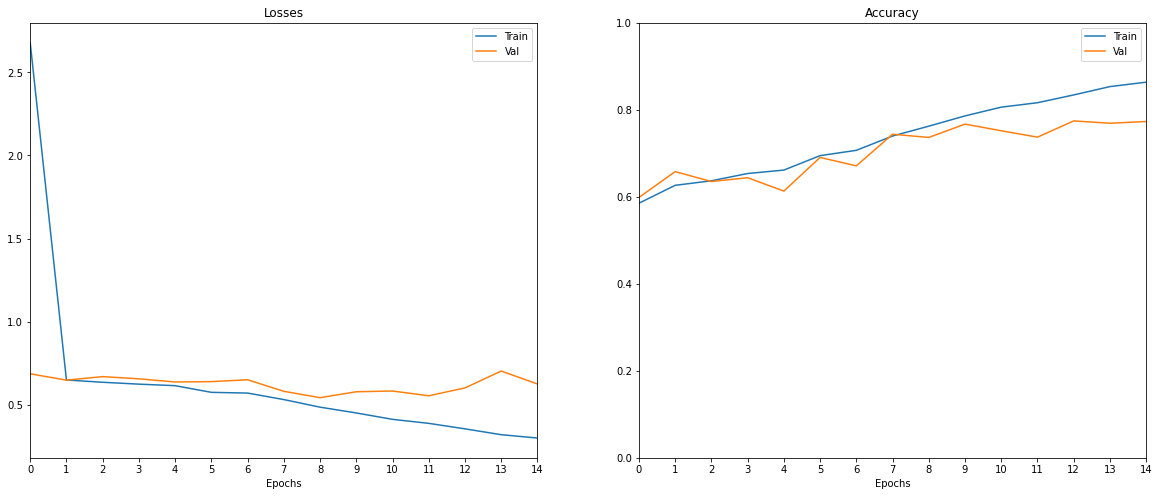

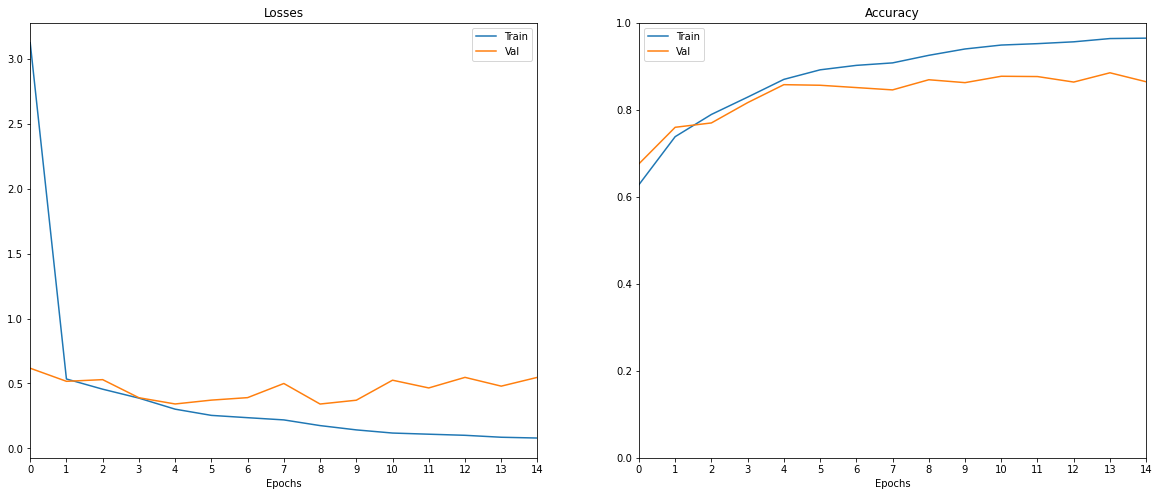

In [27]:
plot_accs_losses(r_ta, r_tl, r_va, r_vl, epoch_num)
plot_accs_losses(f_ta, f_tl, f_va, f_vl, epoch_num)

### Plot the accuracy and loss for the training, but using only two graphs instead of four

(0.0, 1.0)

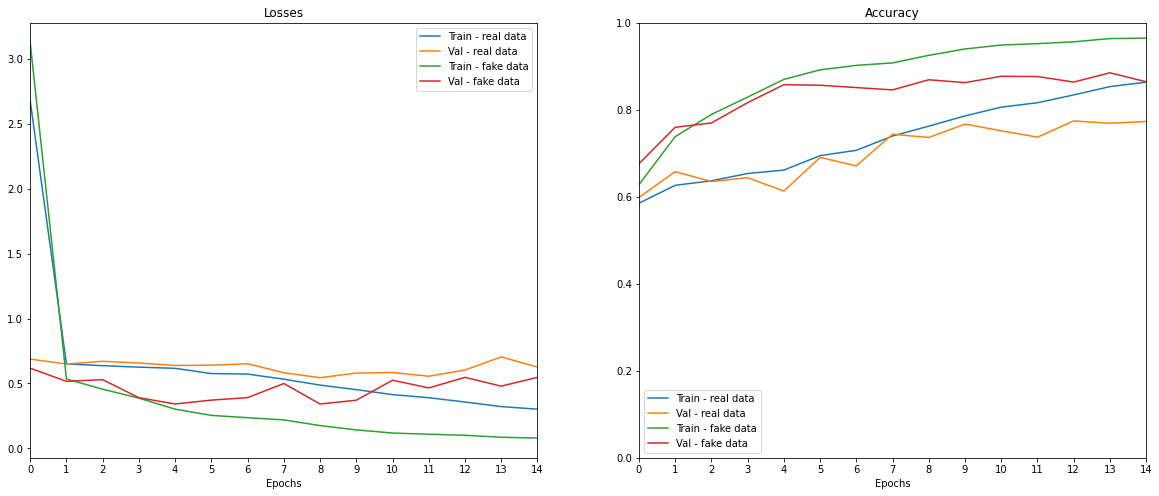

In [30]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(20, 8)

axes[0].plot(r_tl)
axes[0].plot(r_vl)
axes[0].plot(f_tl)
axes[0].plot(f_vl)
axes[0].legend(["Train - real data", "Val - real data", "Train - fake data", "Val - fake data"])
axes[0].set_title("Losses")
axes[0].set_xlabel("Epochs")
axes[0].set_xticks(range(epoch_num))
axes[0].set_xlim([0, epoch_num - 1])
# axes[0].set_ylim([0, max(max(train_losses), max(val_losses))])

axes[1].plot(r_ta)
axes[1].plot(r_va)
axes[1].plot(f_ta)
axes[1].plot(f_va)
axes[1].legend(["Train - real data", "Val - real data", "Train - fake data", "Val - fake data"])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_xticks(range(epoch_num))
axes[1].set_xlim([0, epoch_num - 1])
axes[1].set_ylim([0, 1])

## Compare how well the two CNNs do on the real and generated validation sets

In [28]:
rm_rd_acc, rm_rd_loss = evaluate_model(r_dl_val, r_ds_val, eval_real, loss_fn)
rm_fd_acc, rm_fd_loss = evaluate_model(f_dl_val, f_ds_val, eval_real, loss_fn)
fm_rd_acc, fm_rd_loss = evaluate_model(r_dl_val, r_ds_val, eval_fake, loss_fn)
fm_fd_acc, fm_fd_loss = evaluate_model(f_dl_val, f_ds_val, eval_fake, loss_fn)

print("Real model + real data acc: {:.3f}\taverage loss: {:.3f}".format(rm_rd_acc, rm_rd_loss))
print("Real model + fake data acc: {:.3f}\taverage loss: {:.3f}".format(rm_fd_acc, rm_fd_loss))
print("Fake model + real data acc: {:.3f}\taverage loss: {:.3f}".format(fm_rd_acc, fm_rd_loss))
print("Fake model + fake data acc: {:.3f}\taverage loss: {:.3f}".format(fm_fd_acc, fm_fd_loss))

Real model + real data acc: 0.775	average loss: 0.619
Real model + fake data acc: 0.643	average loss: 0.861
Fake model + real data acc: 0.593	average loss: 2.001
Fake model + fake data acc: 0.864	average loss: 0.544
